# Chap 03.01. AutoEncoder

----

Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)

----

- Ref : https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main/notebooks/03_vae/01_autoencoder

## 0. Import Libraries

In [51]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

## 1. Parameters

In [52]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

## 2. Prepare Data

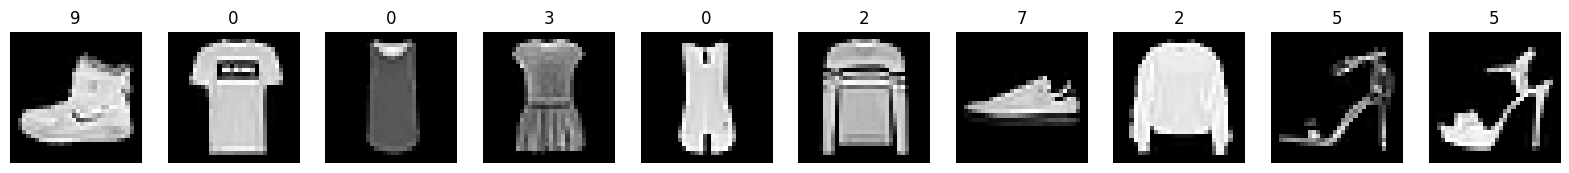

In [53]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

# Preprocess the data
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Show some items of clothing from the training set
plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
    plt.title(y_train[i])
plt.show()

## 3. Build Autoencoder Netwrok

In [54]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

# print(shape_before_flattening)
# print(np.prod(shape_before_flattening))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (37

In [55]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 32)        1846

In [56]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_6 (Functional)        (None, 32, 32, 1)         2462

## 4.Train the AutoEncoder Model

In [57]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./temp/checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./temp/logs")

# Training
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

# Save the final models
autoencoder.save("./temp/models/autoencoder")
encoder.save("./temp/models/encoder")
decoder.save("./temp/models/decoder")

Epoch 1/3
599/600 [============================>.] - ETA: 0s - loss: 0.2958INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


600/600 [==============================] - 8s 12ms/step - loss: 0.2957 - val_loss: 0.2655
Epoch 2/3
598/600 [============================>.] - ETA: 0s - loss: 0.2569INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


600/600 [==============================] - 6s 11ms/step - loss: 0.2569 - val_loss: 0.2559
Epoch 3/3
599/600 [============================>.] - ETA: 0s - loss: 0.2535INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


INFO:tensorflow:Assets written to: ./temp/checkpoint/assets


600/600 [==============================] - 7s 11ms/step - loss: 0.2535 - val_loss: 0.2536
INFO:tensorflow:Assets written to: ./temp/models/autoencoder/assets


INFO:tensorflow:Assets written to: ./temp/models/autoencoder/assets


INFO:tensorflow:Assets written to: ./temp/models/encoder/assets


INFO:tensorflow:Assets written to: ./temp/models/encoder/assets


INFO:tensorflow:Assets written to: ./temp/models/decoder/assets


INFO:tensorflow:Assets written to: ./temp/models/decoder/assets


## 5. Test

157/157 [==============================] - 1s 3ms/step


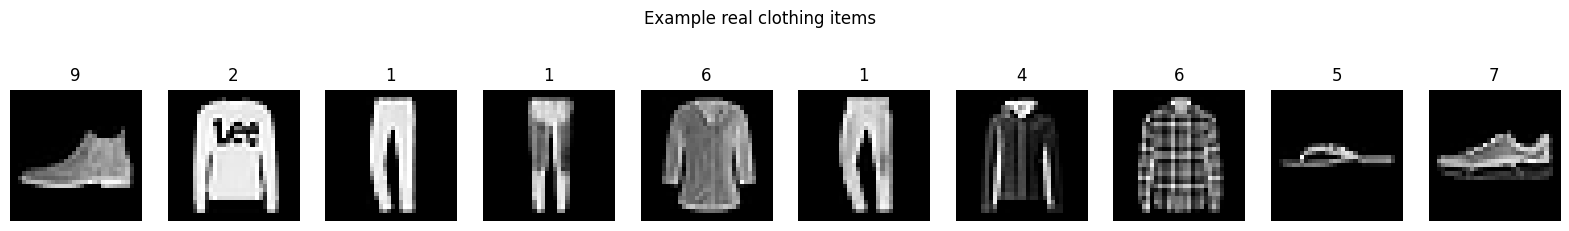

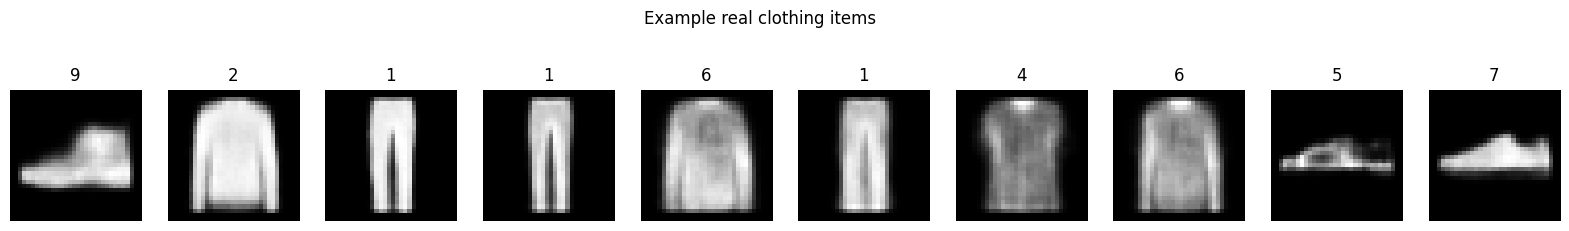

In [58]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

predictions = autoencoder.predict(example_images)


plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(example_images[i], cmap="gray")
    plt.axis("off")
    plt.title(example_labels[i])
plt.suptitle("Example real clothing items")
plt.show()

plt.figure(figsize=(20, 3))
for i in range(10):
    _ = plt.subplot(1, 10, i + 1)
    plt.imshow(predictions[i], cmap="gray")
    plt.axis("off")
    plt.title(example_labels[i])
plt.suptitle("Example real clothing items")
plt.show()

## 6. Check Embeded value with the Encoder

157/157 [==============================] - 0s 1ms/step
[[ 0.90884674 -1.924992  ]
 [-3.006557    3.2353017 ]
 [-8.036108   -4.7354946 ]
 [-5.4739065  -4.1320066 ]
 [-1.3787014   1.5209775 ]
 [-5.481658   -2.0987918 ]
 [-2.2731256  -0.04578775]
 [-1.7379586   1.048053  ]
 [ 1.915597   -5.035261  ]
 [ 2.696239   -3.3581793 ]]


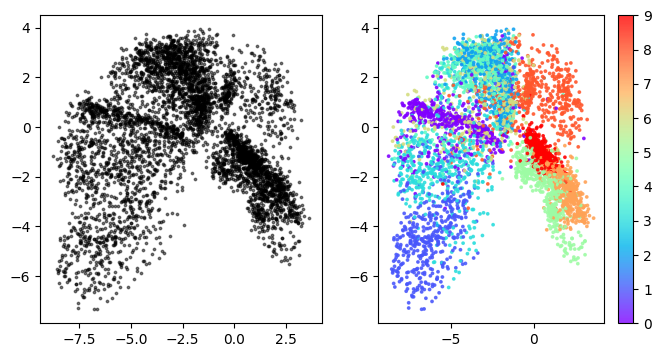

In [59]:
# Encode the example images
embeddings = encoder.predict(example_images)

# Some examples of the embeddings
print(embeddings[:10])

# Show the encoded points in 2D space
figsize = 4
plt.figure(figsize=(figsize * 2, figsize))
_ = plt.subplot(1, 2, 1)
plt.scatter(embeddings[:, 0],
            embeddings[:, 1],
            c="black",
            alpha=0.5,
            s=3)
_ = plt.subplot(1, 2, 2)
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()


## 7. Generate using the decoder

In [60]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)


In [61]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 66ms/step


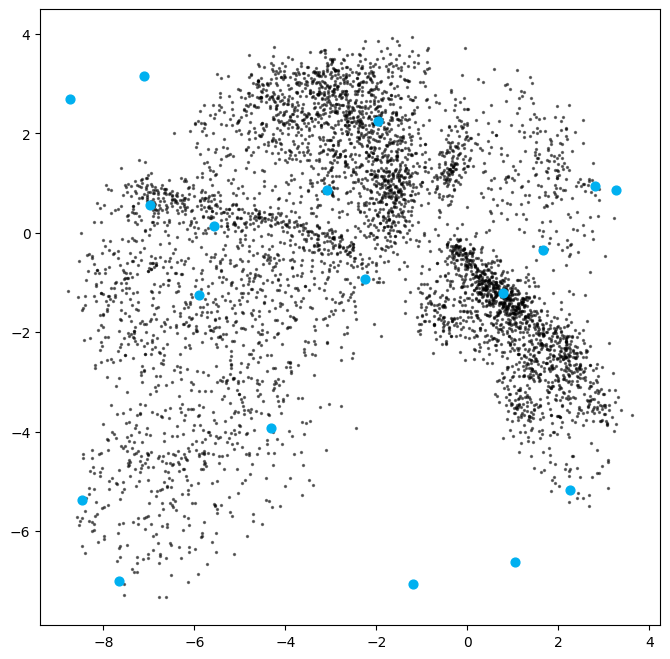

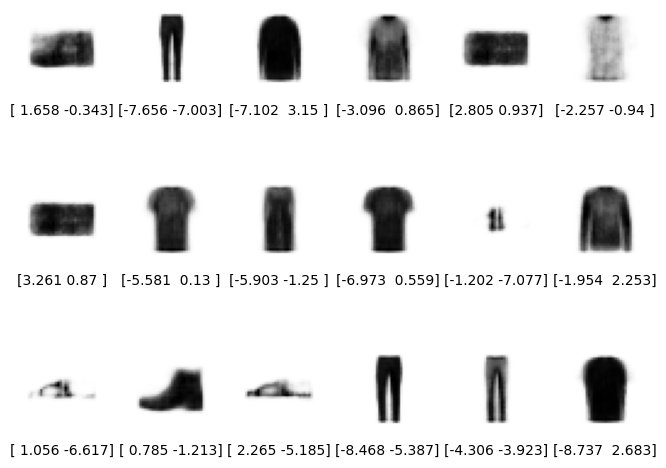

In [62]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 3)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 5ms/step


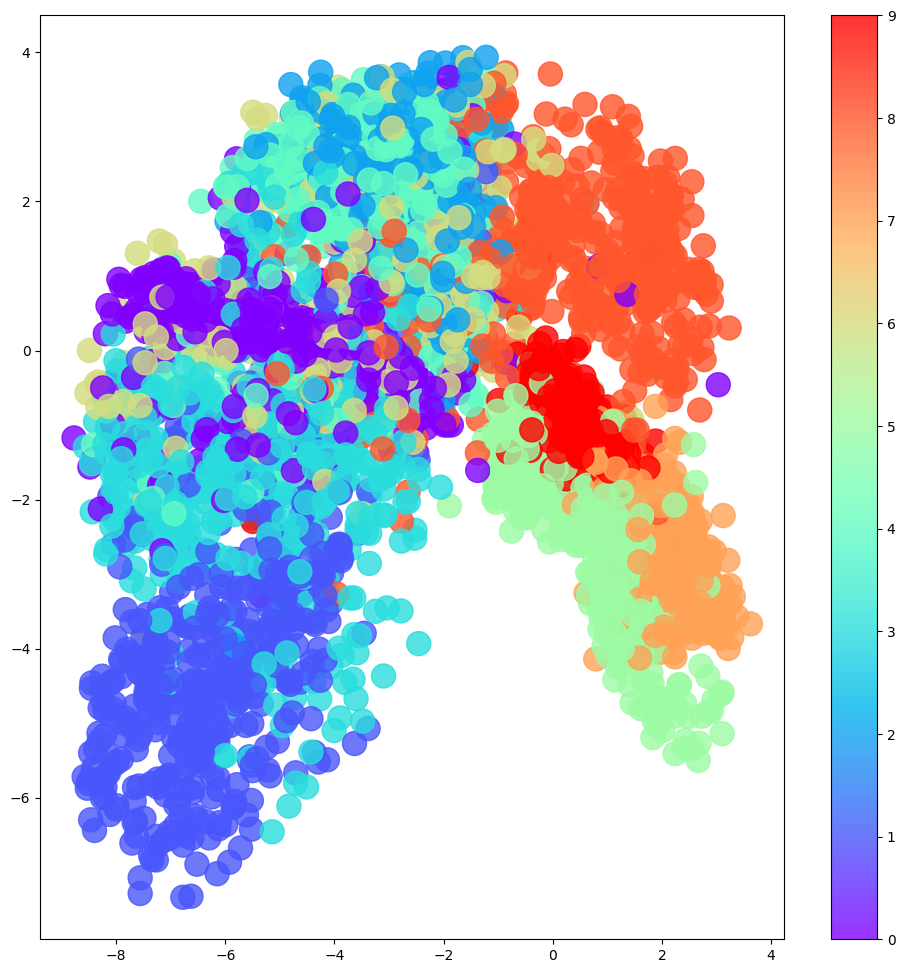

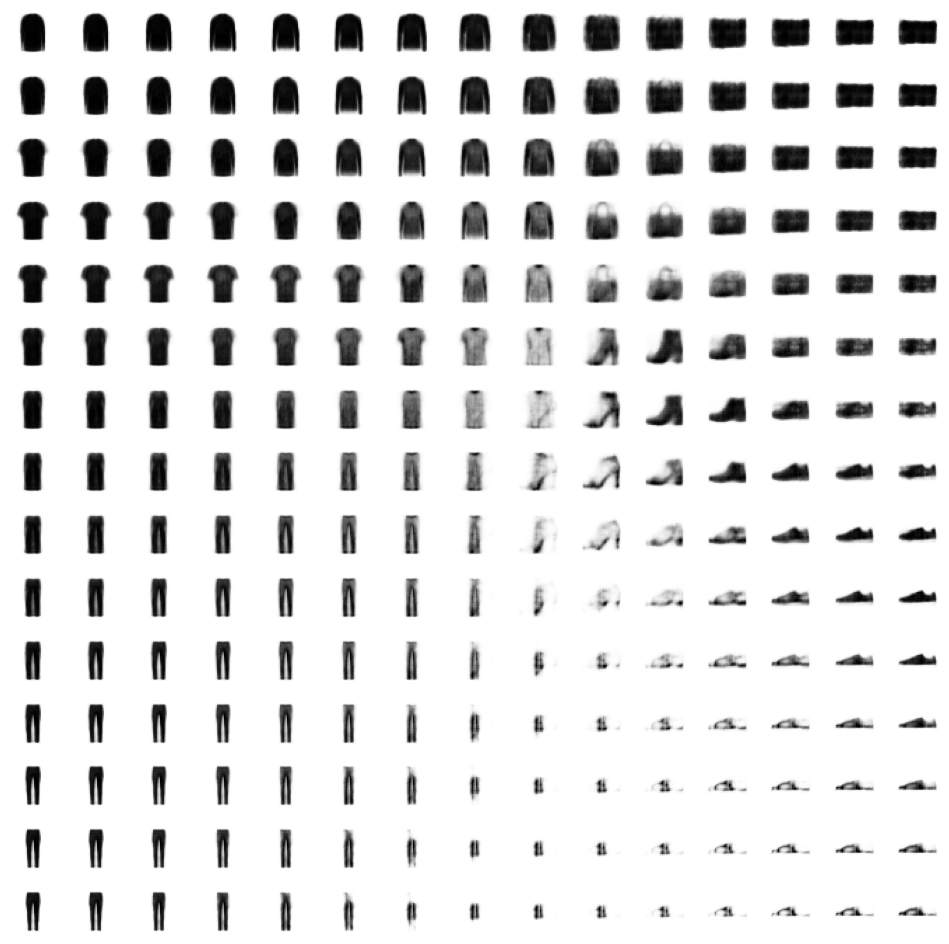

In [63]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")